In [159]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TiDEModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas_ta as ta

In [160]:
# Load and preprocess data
file_path = "./taiwan_mobile_stock_data_cleaned.csv"
# file_path = "./china_steel_stock_data_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]

In [161]:
# Feature engineering
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['RSI'] = ta.rsi(data['Close'], length=14)
data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()
data['Price_Range'] = data['High'] - data['Low']
data['Daily_Return'] = ((data['Close'] - data['Open']) / data['Open']) * 100
data['Volume_Change'] = data['Volume'].pct_change() * 100

# Drop NaN values and retain numerical columns
data = data.dropna().select_dtypes(include=[np.number]).astype(np.float32)

# Define features and target
features = ['Close', 'MA_5', 'MA_10', 'RSI', 'Volume_MA_5', 'Price_Range', 'Daily_Return', 'Volume_Change']
target = 'Close'

In [162]:
# Scale data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)
target_scaler = MinMaxScaler()
scaled_data[target] = target_scaler.fit_transform(data[[target]])

# Ensure time series consistency
scaled_data.index = pd.to_datetime(scaled_data.index)
scaled_data = scaled_data.asfreq('B', method='ffill')

# Convert data to TimeSeries
series = TimeSeries.from_dataframe(scaled_data, value_cols=target, freq='B', fill_missing_dates=True, fillna_value=0)

In [231]:
# Split data into training, validation, and test sets
train_size = int(len(series) * 0.9)
valid_size = int(len(series) * 0.9)

train_series = series[:train_size]
valid_series = series[train_size:valid_size]
test_series = series[valid_size:]

In [232]:
# Define inverse scaling function
def inverse_scale(target_scaler, predictions):
    return target_scaler.inverse_transform(predictions)

In [233]:
# TiDE model setup and training
model = TiDEModel(input_chunk_length=30, output_chunk_length=5)
model.fit(train_series)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 24.4 K | train
6 | decoders         | Sequential       | 37.2 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 155    | train
--------------------------------------------------------------
62.3 K    Trainable params
0         Non-trainable params
62.3 K    Total params
0.249     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval 

Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 84.83it/s, train_loss=0.00188]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00, 84.11it/s, train_loss=0.00188]


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=30, output_chunk_length=5)

In [234]:
# Test predictions
y_test_pred_scaled = model.predict(n=len(test_series))
y_test_pred = inverse_scale(target_scaler, y_test_pred_scaled.values())

# Calculate test MSE
test_mse = mean_squared_error(test_series.values().flatten(), y_test_pred.flatten())
print(f"Test MSE (inverse scaled): {test_mse:.4f}")

# Inverse scale the actual test values
actual_test = inverse_scale(target_scaler, test_series.values())

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.18it/s]
Test MSE (inverse scaled): 12606.0820


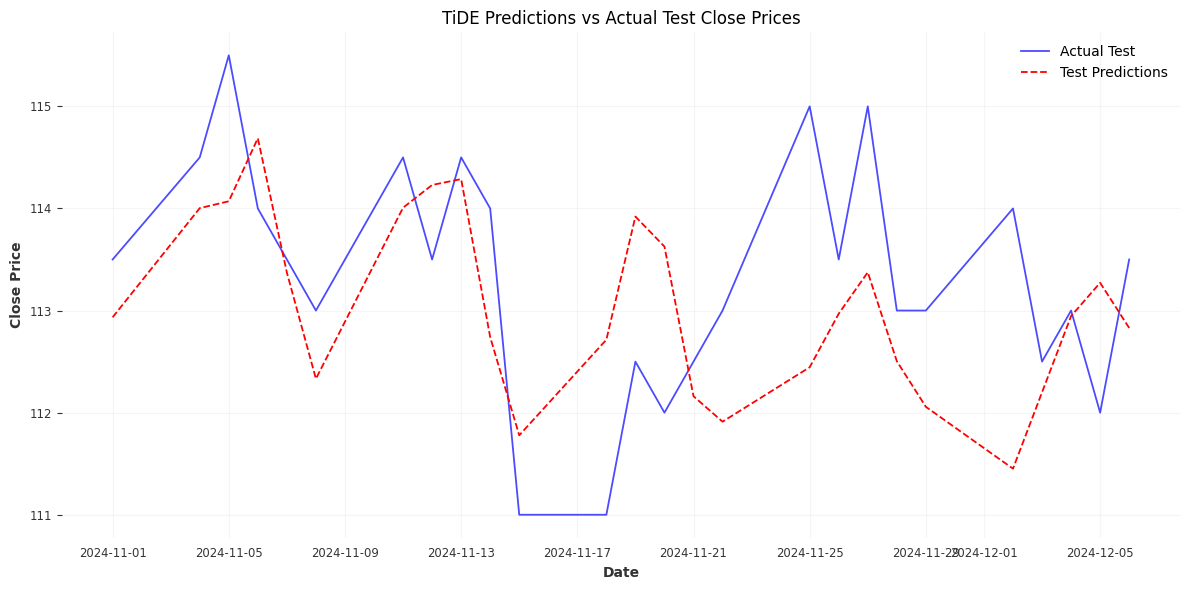

In [235]:
# Plot the test predictions and the actual test values
plt.figure(figsize=(12, 6))

# Plot actual Close prices (trimmed to match test period)
plt.plot(test_series.time_index, actual_test.flatten(), label="Actual Test", color="blue", alpha=0.7)

# Plot predictions
plt.plot(test_series.time_index, y_test_pred.flatten(), label="Test Predictions", color="red", linestyle="--")

# Add title and labels
plt.legend()
plt.title("TiDE Predictions vs Actual Test Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

In [236]:
# Predict the next 5 days
future_predictions_scaled = model.predict(n=5)
future_predictions = inverse_scale(target_scaler, future_predictions_scaled.values())

# Print predictions
print("Predicted Close Prices for the Next 5 Days:")
for i, value in enumerate(future_predictions.flatten(), 1):
    print(f"Day {i}: {value:.2f}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.60it/s]
Predicted Close Prices for the Next 5 Days:
Day 1: 112.93
Day 2: 114.00
Day 3: 114.07
Day 4: 114.69
Day 5: 113.37
